# Set up

In [1]:
import torch
import pandas as pd
import numpy as np
import tqdm as tqdm

import matplotlib.pyplot as plt

import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels


from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

import pickle

In [2]:
Device = 'cpu'

# Data

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


# Emulator Result

In [ ]:
loaded_samples_chain1 = torch.load("mcmc_samples_2.pt", map_location=Device)

In [ ]:
loaded_samples_chain2 = torch.load("mcmc_samples_1.pt", map_location=Device)

# MCMC V 2 chains

In [ ]:
autocorrelation(loaded_samples_chain1['param_0'], dim=0)

In [ ]:
statsmodels.tsa.stattools.acf(loaded_samples_chain1['param_0'], nlags=1199)

In [ ]:
true_params_tensor = test_x[0]

param_names = sorted(list(loaded_samples_chain1.keys()))

true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}


mcmc_samples = {}
for param in loaded_samples_chain1.keys():
    mcmc_samples[param] = torch.stack([loaded_samples_chain1[param], loaded_samples_chain2[param]])

n_chains = 2
diagnostics_results = {}

for param, samples_chains in mcmc_samples.items():
    true_value = true_params[param]
    n_samples = samples_chains.shape[1]
    
    # rhat ...
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    
    diagnostics_results[param] = {
         "R-hat": rhat.item(),
         "Split R-hat": split_rhat.item(),
         "Effective Sample Size": ess.item()
    }
    print(f"{param}: R-hat = {rhat.item():.3f}, split R-hat = {split_rhat.item():.3f}, ESS = {ess.item():.1f}")
    
    # Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(n_chains):
         plt.plot(samples_chains[i].numpy(), marker='o', label=f"Chain {i+1}")
    plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # Quantiles
    plt.subplot(1, 2, 2)
    all_samples = samples_chains.flatten()
    plt.hist(all_samples.numpy(), bins=15, density=True, alpha=0.7, color='gray')
    plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = quantile(all_samples, probs=[0.025, 0.5, 0.975], dim=0)
    for q in qs:
         plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    plt.title(f"Histogram with Quantiles for {param}")
    plt.xlabel("Parameter Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

    # ACF
    plot_acf(samples_chains[0].numpy(), lags=50)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title(f"ACF Plot for {param} (Chain 1)")
    plt.show()

    
#     acf = autocorrelation(mcmc_samples[param], dim=0)
#     plt.figure(figsize=(6, 4))
#     plt.plot(acf.numpy(), marker='o')
#     plt.title(f"Autocorrelation for {param} (Chain 1)")
#     plt.xlabel("Lag")
#     plt.ylabel("Autocorrelation")
#     plt.show()
    
    # Weighed Quantile
    # 使用均匀权重（对数权重为0）时，带权重分位数应与普通分位数一致
#     log_weights = torch.zeros_like(samples)
#     wq = weighed_quantile(samples, probs=[0.025, 0.5, 0.975], log_weights=log_weights, dim=0)
#     print(f"{param} weighed quantiles: {wq}\n")


# MCMC V 1 chain

In [6]:
with open("Result/L.MGP_21_mcmc_result/result_10.pkl", "rb") as f:
    loaded_samples_chain1 = pickle.load(f)

param_0: R-hat = 0.999, split R-hat = 0.999, ESS = 3196.8


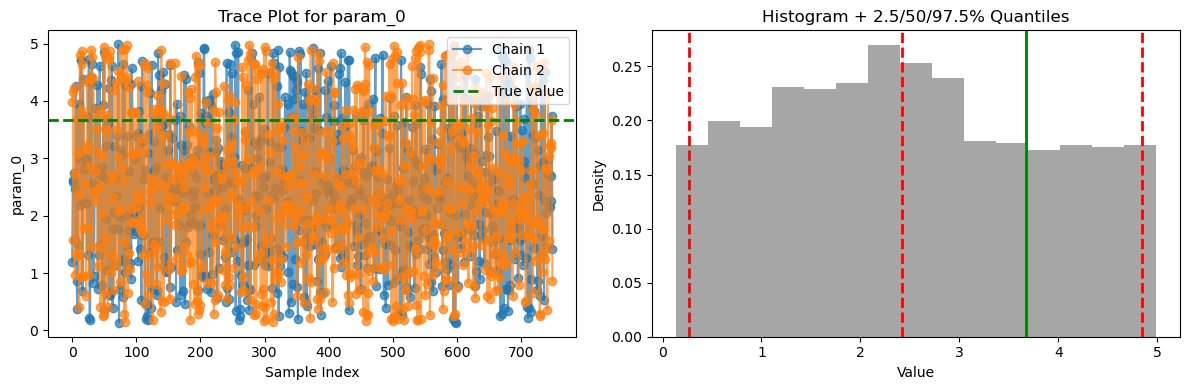

<Figure size 600x400 with 0 Axes>

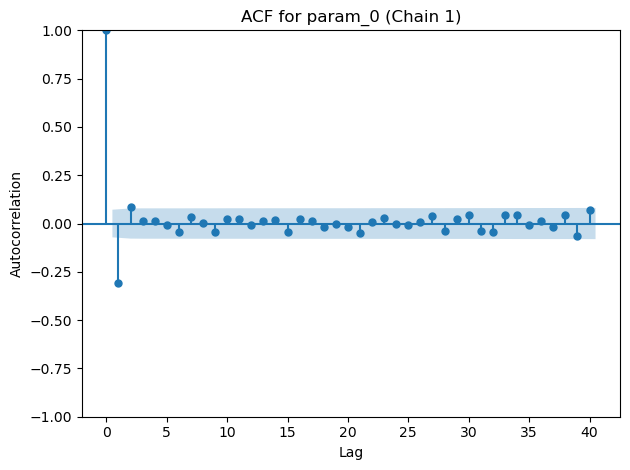

param_1: R-hat = 0.999, split R-hat = 0.999, ESS = 2930.4


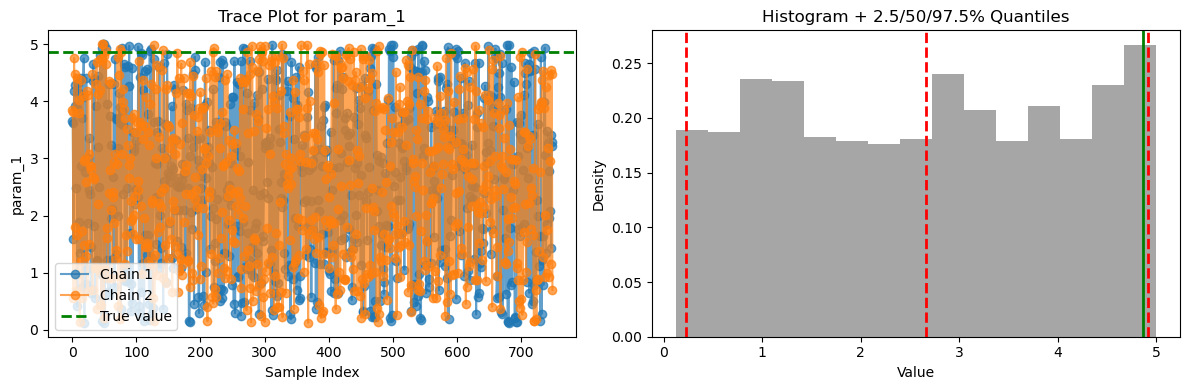

<Figure size 600x400 with 0 Axes>

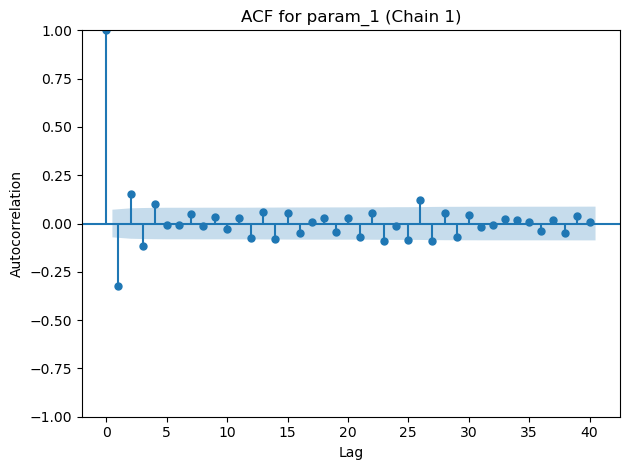

param_2: R-hat = 1.000, split R-hat = 0.999, ESS = 2083.5


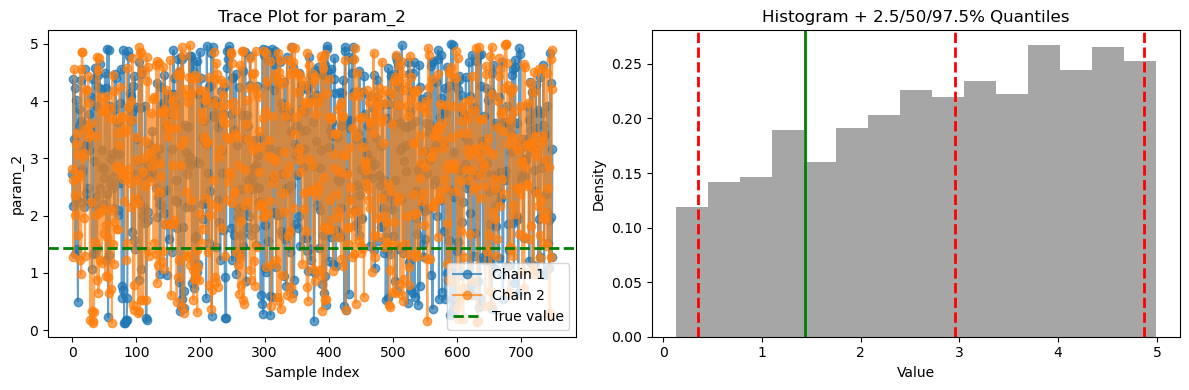

<Figure size 600x400 with 0 Axes>

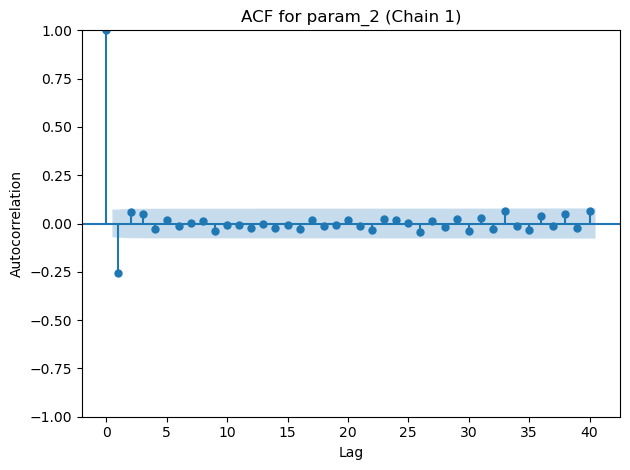

param_3: R-hat = 0.999, split R-hat = 0.999, ESS = 3756.5


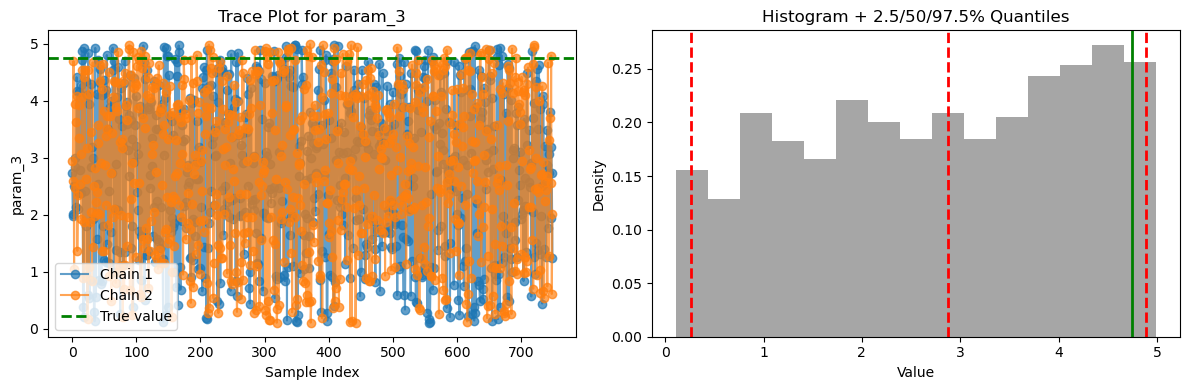

<Figure size 600x400 with 0 Axes>

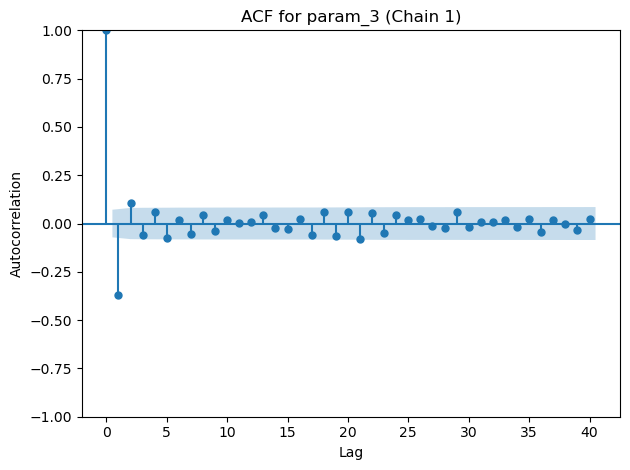

param_4: R-hat = 0.999, split R-hat = 0.999, ESS = 2047.9


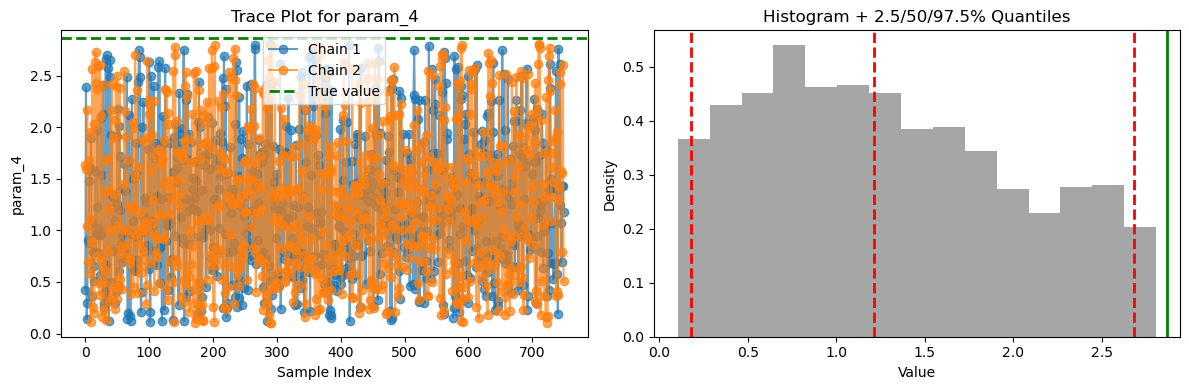

<Figure size 600x400 with 0 Axes>

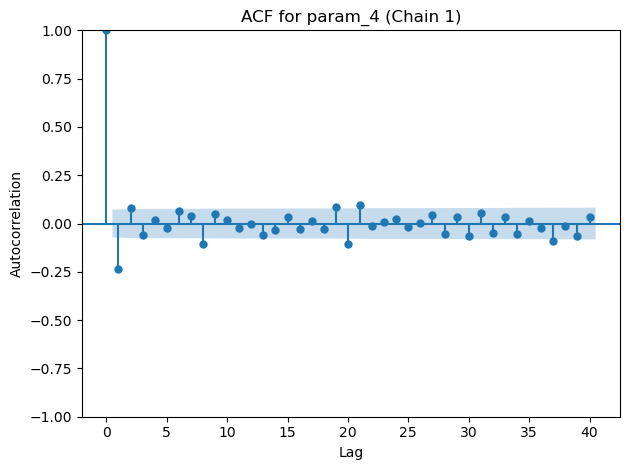

param_5: R-hat = 0.999, split R-hat = 1.001, ESS = 2012.4


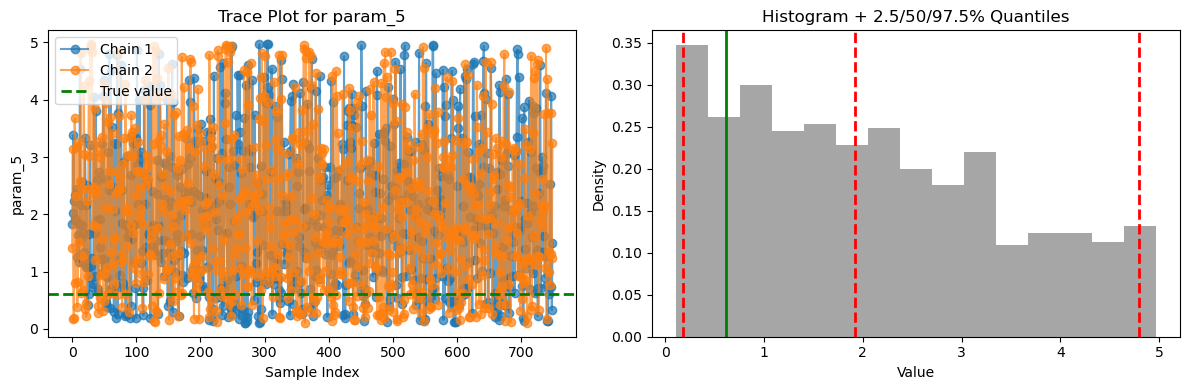

<Figure size 600x400 with 0 Axes>

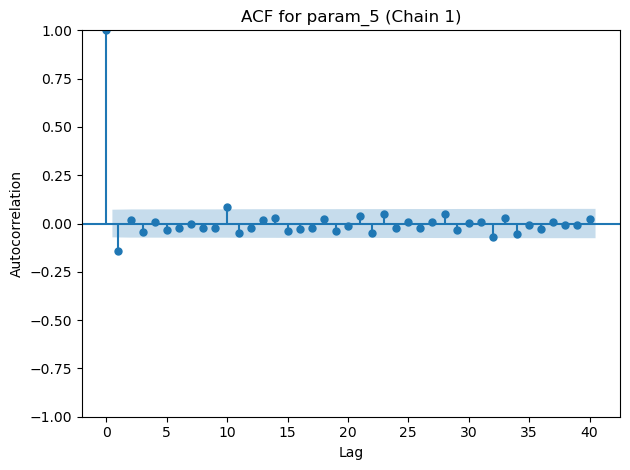

param_6: R-hat = 0.999, split R-hat = 0.999, ESS = 2129.1


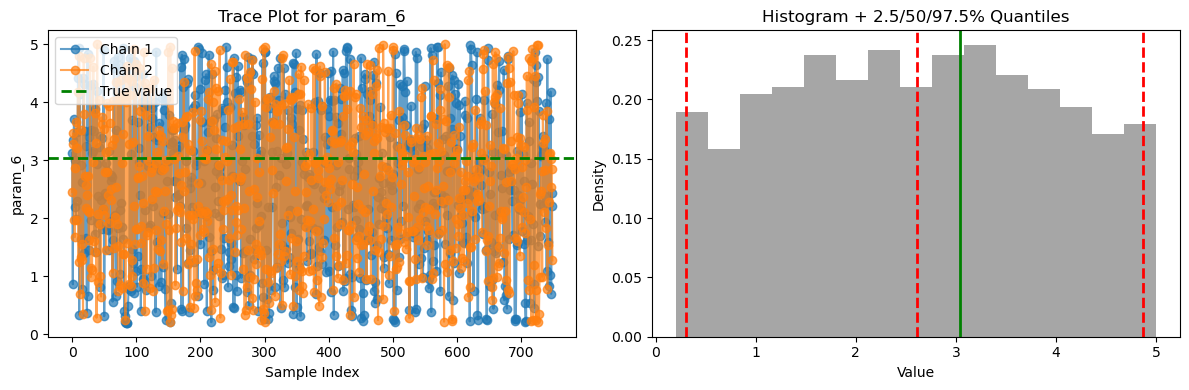

<Figure size 600x400 with 0 Axes>

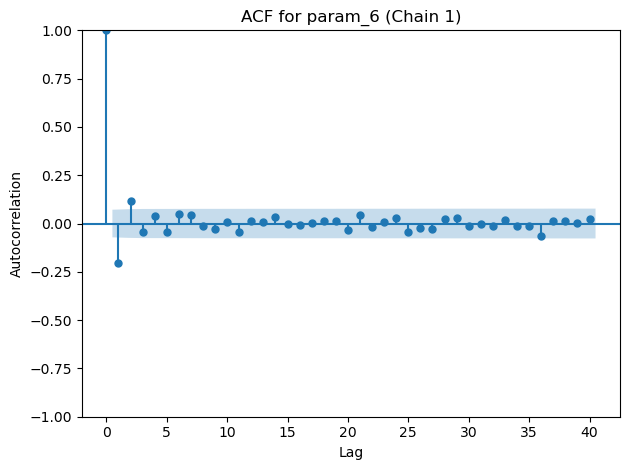

param_7: R-hat = 0.999, split R-hat = 1.004, ESS = 2280.7


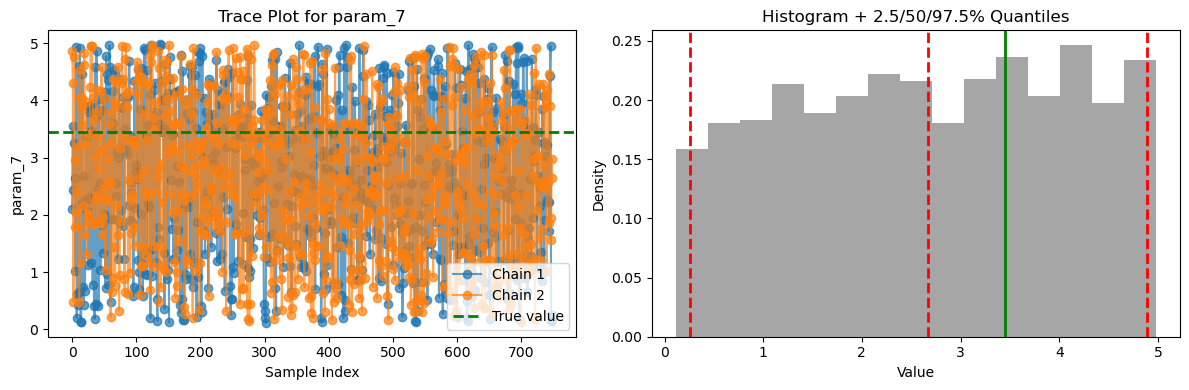

<Figure size 600x400 with 0 Axes>

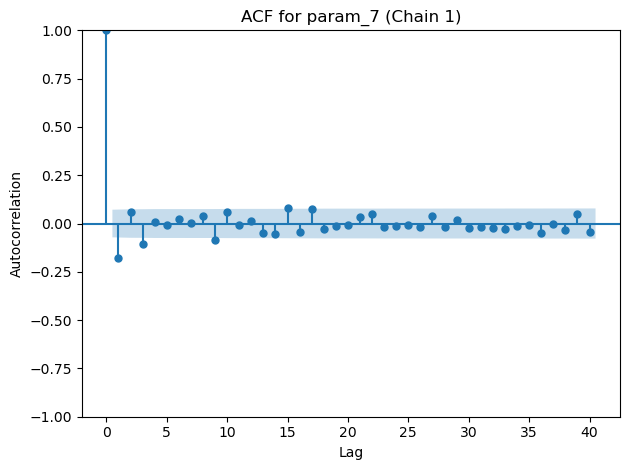

param_8: R-hat = 1.003, split R-hat = 1.001, ESS = 2495.5


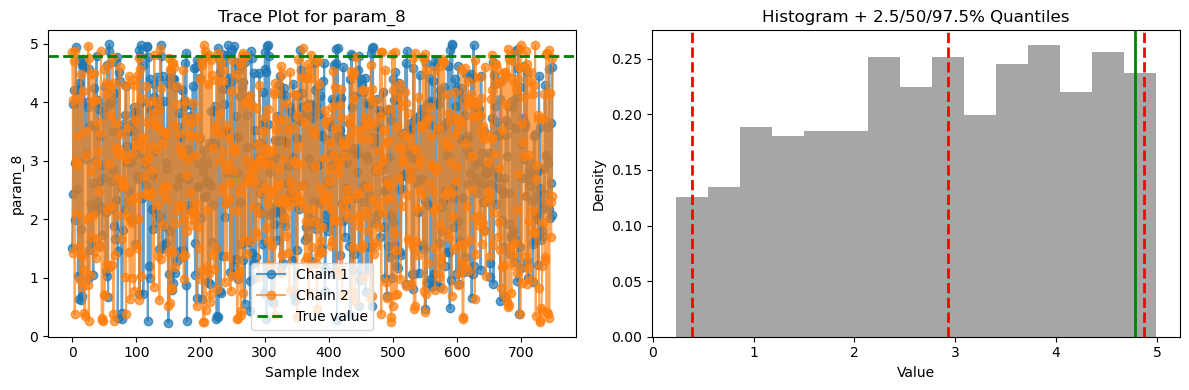

<Figure size 600x400 with 0 Axes>

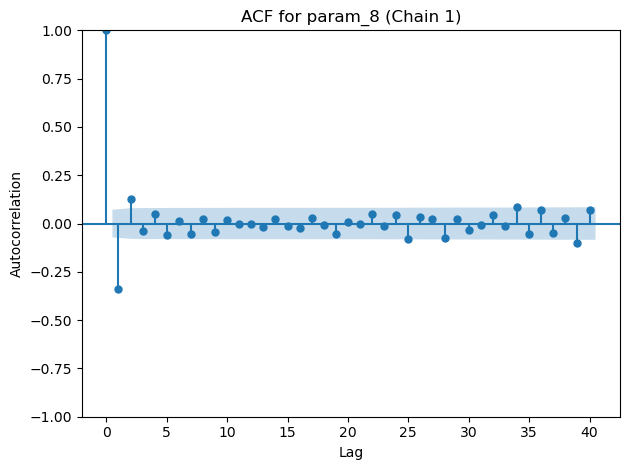

param_9: R-hat = 0.999, split R-hat = 0.999, ESS = 3279.6


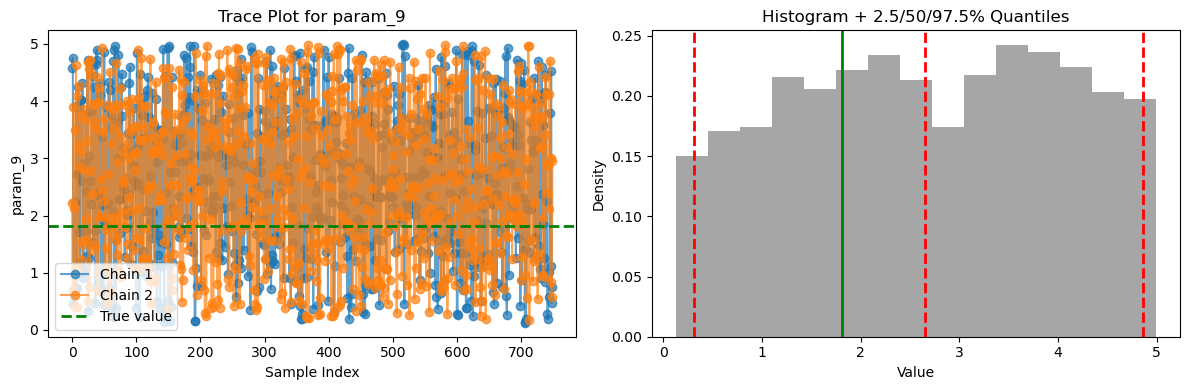

<Figure size 600x400 with 0 Axes>

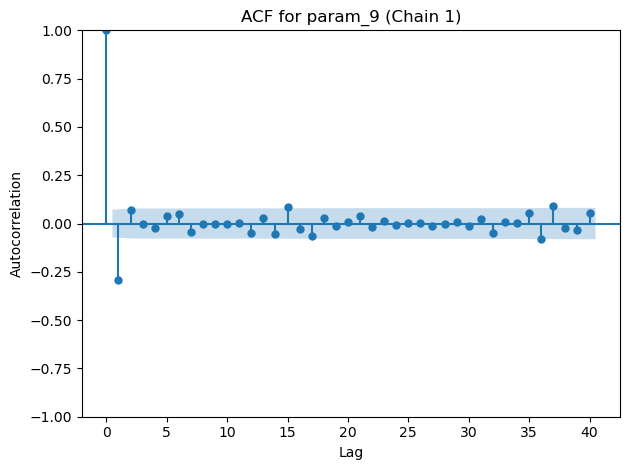

In [7]:
single_chain_samples = loaded_samples_chain1  # dict: param -> Tensor[n_samples]

# 将每条参数的样本拆成两半
def split_chain(chain_tensor):
    n = chain_tensor.shape[0]
    half = n // 2
    return chain_tensor[:half], chain_tensor[half:2*half]

# 整理成 mcmc_samples：param -> Tensor[2, n_half]
mcmc_samples = {}
for param, samples in single_chain_samples.items():
    chain_a, chain_b = split_chain(samples)
    # 如果原链长度是奇数，可以选择丢弃最后一个样本或做其他处理
    mcmc_samples[param] = torch.stack([chain_a, chain_b], dim=0)

# 真实值
param_names = sorted(list(single_chain_samples.keys()))
true_params_tensor = test_x[0]
true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}

# 诊断和可视化
for param, samples_chains in mcmc_samples.items():
    true_value = true_params[param]
    
    # 计算诊断量
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    print(f"{param}: R-hat = {rhat:.3f}, split R-hat = {split_rhat:.3f}, ESS = {ess:.1f}")
    
    # 绘制 Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(samples_chains[i].cpu().numpy(), marker='o', label=f"Chain {i+1}", alpha=0.7)
    plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # 绘制 Histogram + Quantiles
    plt.subplot(1, 2, 2)
    all_samps = samples_chains.reshape(-1).cpu().numpy()
    plt.hist(all_samps, bins=15, density=True, alpha=0.7, color='gray')
    plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = torch.quantile(torch.from_numpy(all_samps), torch.tensor([0.025, 0.5, 0.975]))
    for q in qs:
        plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    plt.title(f"Histogram + 2.5/50/97.5% Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()
    
    # 绘制 ACF（仅第一“伪链”）
    plt.figure(figsize=(6,4))
    plot_acf(samples_chains[0].cpu().numpy(), lags=40)
    plt.title(f"ACF for {param} (Chain 1)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

# End